## Linear Regression

Consider the following linear equation:

\begin{equation}
y_i = \alpha +x_i\beta
\end{equation}

The equation says that there is a linear relation between the variable $x$ and $y$. The parameter $\beta$ controls the slope of the linear relationship and thus is interpreted as the change in the variable $y$ per unit change in the variable $x$. $\alpha$ is known as the intercept, and gives the value of $y$ when $x=0$.

Traditional methods of linear modelling is the least square fit method.

However thiniking probabilistically gives us several advantages, we can obtain the best value of $\alpha$ and $\beta$ together with the uncertainty we have about the parameters value.

Probabilitistically , a linear regression can be modeled as follows:

\begin{equation}
y\sim N\left(\mu=\alpha+x\beta, \epsilon\right)
\end{equation}

This implies that the data vector $y$ is assumed to be distributed as a Gaussian with a mean of $\alpha + x\beta$ and a standard deviation of $\epsilon$. 

Since we do not know the values of $\alpha$, $\beta$ or $\epsilon$ we have to set prior distributions for them. A reasonable choice would be:

\begin{equation}
\alpha \sim N\left(\mu_{\alpha}, \sigma_{\alpha}\right)\\
\beta \sim N\left(\mu_{\beta}, \sigma_{\beta}\right)\\
\epsilon \sim |N\left(0, \sigma_{\epsilon}\right)|
\end{equation}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


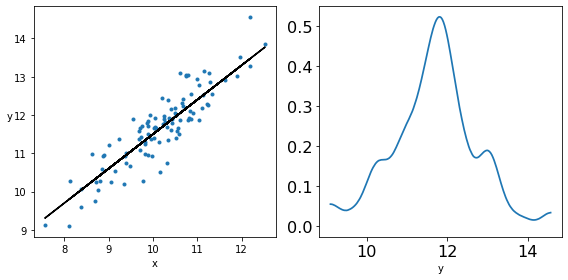

In [2]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

Let us create a linear regression model in pymc3.

In [3]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164597467916465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


$\mu$ is expressed in the model as a deterministic variable. To explore the results of our inference we are going to generate a trace plot, omitting the deterministic variables. We can do this passing only the names of the variables we want to plot.

In [4]:
sns.set()

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

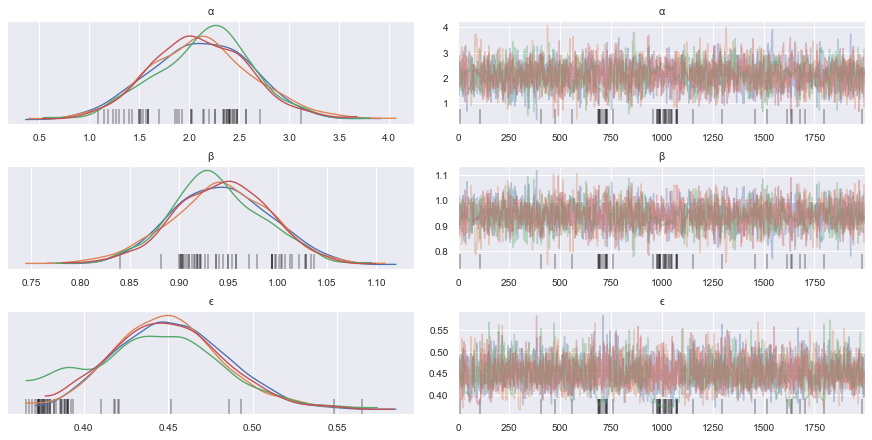

In [5]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])

## Linear models and high auto correlation

Linear models have a posterior distribution where $\alpha$ and $\beta$ are highly correlated. Let us look at the example above:

<AxesSubplot:xlabel='α', ylabel='β'>

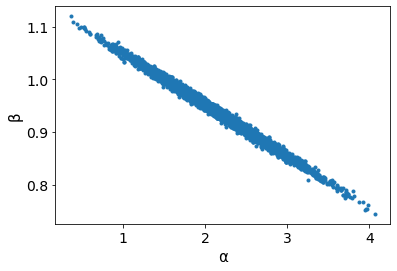

In [30]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.0001})

The correlation that we see is a consequence of one of the key assumptions, that all fitted models should pass through one point, namely the mean of the data $\left(\bar{x}, \bar{y}\right)$.



## Modifying the data before running

One way to remove the correlation between $\alpha$ and $\beta$ is to center $x$ variable. For each $x_i$ data point we subtract the mean $\bar{x}$.
\begin{equation}
x'=x-\bar{x}
\end{equation}
Thus $x'$ will be centered at the origin 0, hence the pivot point when changing the slope is exactly the intercept and the $\alpha$ and $\beta$ are less correlated now.

## Interpreting and visualizing the posterior

For linear regression it would be useful to plot the average line that fits the data, together with the average mean values of $\alpha$ and $\beta$. To reflect the posterior's uncertainty, we can use semi-transparent lines that have beens sampled from the posterior.

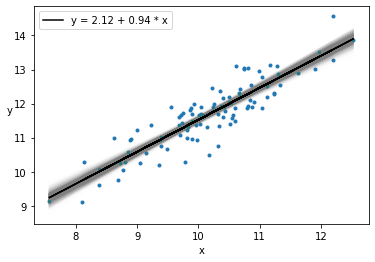

In [9]:
plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.01)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

The uncertainty is lower at the middle of the plot, although it is not reduced to a single point, that is posterior is compatible with lines not exactly passing throgh the mean of the data.

Another interesting fact we can represent on the plot is the HPD interval of $\mu$.

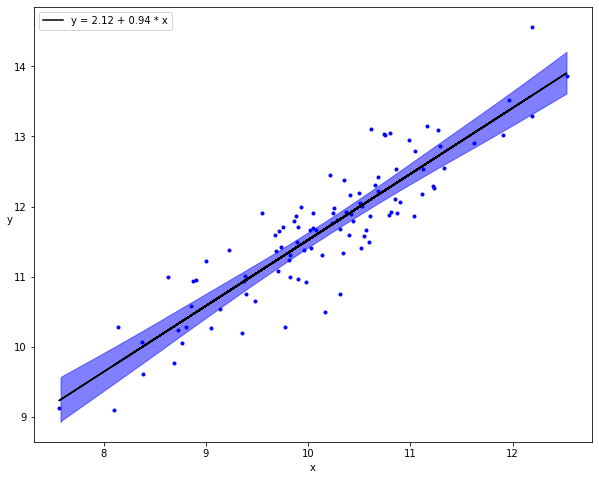

In [19]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'b.')
ax.plot(x, alpha_m + beta_m * x, c='k',          
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x') 
sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='b', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.legend(loc='best')

One more option is to plot the HPD of the predicted data $\hat{y}$, i.e. where we expect to see the 94% and the 50 % of the future data, according to our model.

We can get the posterior predictive samples using the 'sample_posterior_predictive()' function.

In [16]:
ppc = pm.sample_posterior_predictive(trace_g,
                                     samples=2000,
                                     model=model_g)

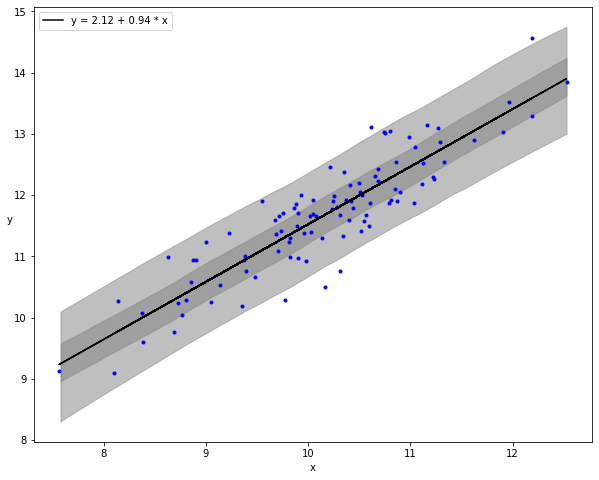

In [23]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'b.')
ax.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray', ax=ax, smooth=True)
az.plot_hpd(x, ppc['y_pred'], color='gray', ax=ax, smooth=True)

ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.legend(loc='best')

The 'az.plot_hpd' function smoothen the interval, in order to remove that, use 'smooth=False' in the options.

# Pearson Correlation Coefficient

Pearson's correlation coefficient, is an efficient to check for linear correlation between two variables. The Pearson's coefficient $r$ is related to the slope of regression:
\begin{equation}
r=\beta\frac{\sigma_x}{\sigma_y}
\end{equation}
Thus the slope $\left(\beta\right)$ and the Pearson correlation coefficient ($r$) are equal iff the standard deviations of $x$ and $y$ are the same. This is true when we standardize the data.

The Pearson coefficient is related to a quantity known as the determination coefficient and for linear regression model this is just the square of the Pearson coefficient, i.e. $r^2$ or $R^2$. It can be intepreted as the proportion of the variance in the dependent variable that is predicted from the independent variable.. For Bayesian linear regression the variance of the predicted values can be larger than the variance of the data and this will lead to $R^2$ larger than 1. A good solution to define the $R^2$ can be as follows:

\begin{equation}
R^2=\frac{V^N_{n=1}E[\hat{y}^s]}{V^N_{n=1}E[\hat{y}^s] + V^S_{n=1}\left(\hat{y}^s-y\right)}
\end{equation}


In the equation above, $E[\hat{y}^s]$ is the expected (or mean) value $\hat{y}$ over $S$ posterior samples.

This is the variance of the predicted values divided by the variance of the predicted values plus the errors (or residuals). This definition has the advantage of ensuring $R^2$ is restricted to the interval $[0,1]$.

In [26]:
az.r2_score(y, ppc['y_pred'])

r2        0.786460
r2_std    0.006192
dtype: float64

## Pearson coefficient from a multi-variate Gaussian

Another way to compute the Pearson coefficient is by estimating the covariance matrix of a multivariate distribution. A multivariate Gaussian distribution is the generalization of the Gaussian distribution to more than one dimension. Let us look into the case of two dimensions.

To fully describe a bivariate Gaussian distribution, we need two means one per each marginal Gaussian. However in addition to the two standarrd deviations we would need the covariance as well:

\begin{equation}
\Sigma = 
\begin{bmatrix}
\sigma_{x_1}^2 & \rho\sigma_{x_1}\sigma_{x_2}\\
\rho\sigma_{x_1}\sigma_{x_2} & \sigma_{x_2}^2
\end{bmatrix}
\end{equation}

where $\Sigma$ is the covariance matrix. In the main diagonal we have the variances of each variable. The rest of the elements are the covariances, $\rho$ is the Pearson's correlation coefficient. We have only one Pearson's coefficient as we have only two variables.

In [32]:
from scipy import stats

Text(-0.05, 0.5, 'x_2')

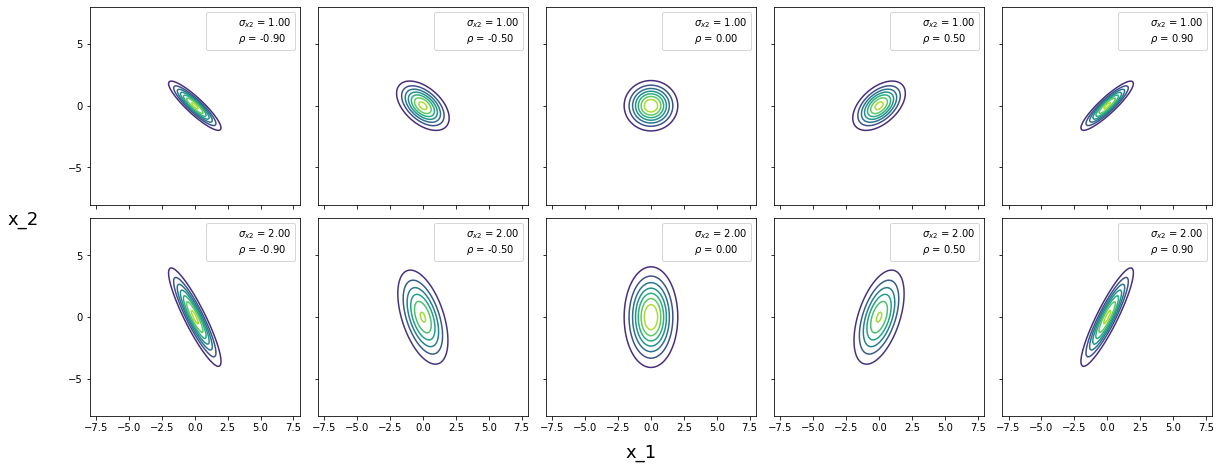

In [36]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(16, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

Now that we know the multivariate Gaussian distribution we can now use it to estimate the Pearson's correlation coefficient. Since  we do not know the values of the covariances we have to put priors on it. One solution is to use the Wishart distribution, which is the conjugate prior of the inverse of the covariance matrix of a multivariate normal. A second option would be to use the LKJ prior, this is a prior for the correlation matrix and not the covariance matrix. The third option is to go for individual priors for $\sigma_{x_1}$, $\sigma_{x_2}$ and $\rho$, and then use these values to manually build the covariance matrix.

In [37]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, σ_2, σ_1, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

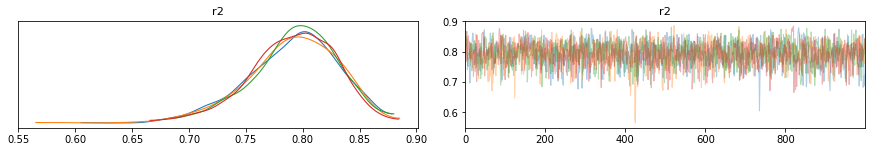

In [38]:
az.plot_trace(trace_p, var_names=['r2'])

In [42]:
az.summary(trace_p,)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ[0]  10.148  0.096   9.963   10.318      0.002    0.002    1829.0  1829.0   
μ[1]  11.662  0.101  11.461   11.841      0.002    0.002    1745.0  1745.0   
σ_1    0.947  0.069   0.823    1.077      0.002    0.001    1912.0  1908.0   
σ_2    0.998  0.072   0.863    1.133      0.002    0.001    1970.0  1957.0   
ρ      0.890  0.022   0.848    0.928      0.000    0.000    1930.0  1930.0   
r2     0.792  0.038   0.716    0.858      0.001    0.001    1930.0  1930.0   

      ess_bulk  ess_tail  r_hat  
μ[0]    1829.0    2013.0    1.0  
μ[1]    1751.0    1895.0    1.0  
σ_1     1930.0    2388.0    1.0  
σ_2     1996.0    2358.0    1.0  
ρ       1927.0    2024.0    1.0  
r2      1927.0    2024.0    1.0

array([<AxesSubplot:title={'center':'μ\n0'}>,
       <AxesSubplot:title={'center':'μ\n1'}>,
       <AxesSubplot:title={'center':'σ_1'}>,
       <AxesSubplot:title={'center':'σ_2'}>,
       <AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'r2'}>], dtype=object)

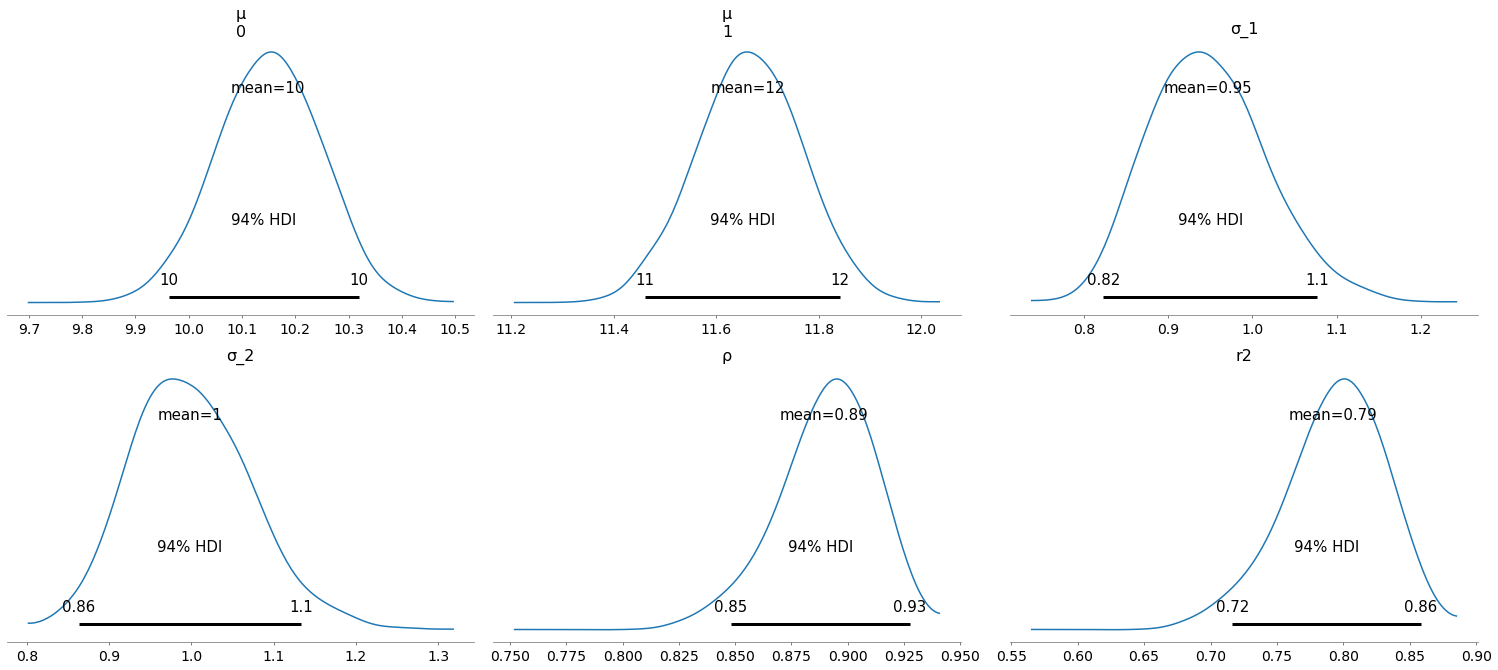

In [44]:
az.plot_posterior(trace_p)

## Robust Linear Regression
When we assume Gaussian distribution for most of the data, we are not necessarily saying that the data is really is Gaussian, what we are saying is that it is a reasonable assumption.

For example in case of presence of outliers, a Student's t-distribution will probably be a better assumption.

In order to demonstrate this we will be using the third dataset from the Anschombe's quartet.

In [45]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

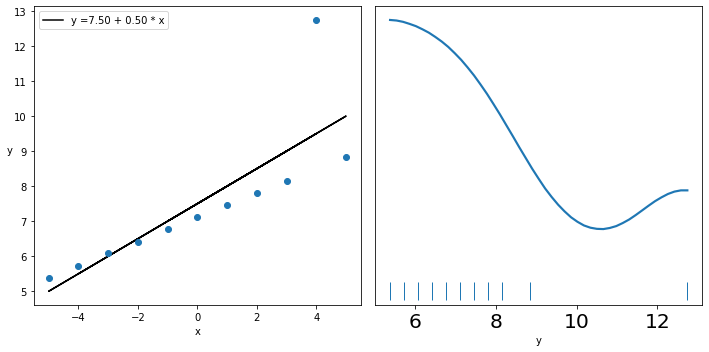

In [46]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

We are going to use the previous model (model_g), but instead of using the Gaussian distribution we will be using the Student's t-distribution. 

In the model being used, we are using a shifted exponential to avoid values of $\nu$ close to zero. 

In [47]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 49 seconds.
The number of effective samples is smaller than 10% for some parameters.


Let's call model_t as the robust fit compared to the scipy's linear regression which we shall call the non-robust fit. Let us compare the two fits: 

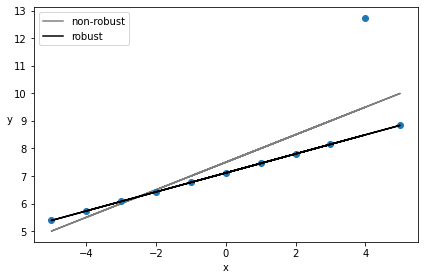

In [48]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

While the non-robust fit tries to compromise and include all points , the robust Bayesian model, model_t automatically discards the one point and fits a line exactly through the remaining points. This is because a Student's t distribution is able to give less importance to points that are far away from the bulk due to the heavier tail distributions.

In [50]:
az.summary(trace_t)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α   7.114  0.001   7.111    7.117      0.000    0.000    4313.0  4312.0   
β   0.345  0.000   0.345    0.346      0.000    0.000    3660.0  3655.0   
ϵ   0.003  0.002   0.001    0.006      0.000    0.000    1455.0  1455.0   
ν_  0.208  0.202   0.000    0.568      0.003    0.002    5214.0  5214.0   
ν   1.208  0.202   1.000    1.568      0.003    0.002    5214.0  5214.0   

    ess_bulk  ess_tail  r_hat  
α     4549.0    3501.0   1.00  
β     4250.0    3342.0   1.00  
ϵ      774.0     345.0   1.00  
ν_    1949.0     506.0   1.01  
ν     1949.0     506.0   1.01

The values of $\alpha, \beta\text{ and }\epsilon$ are very narroly defined (with near zero standard deviations). This is reasonable as we are fitting a line to a perfectly aligned set of points. Let us run a posterior predictive check to explore how our model captures the data:

In [51]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t, random_seed=2)

data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)

## Hierarchical Linear Regression

Hierarchical models allow us to deal with inferences at group level and estimations above the group level, this we do by including hyperpriors.

We are going to create eight related data groups including one group with single data point.

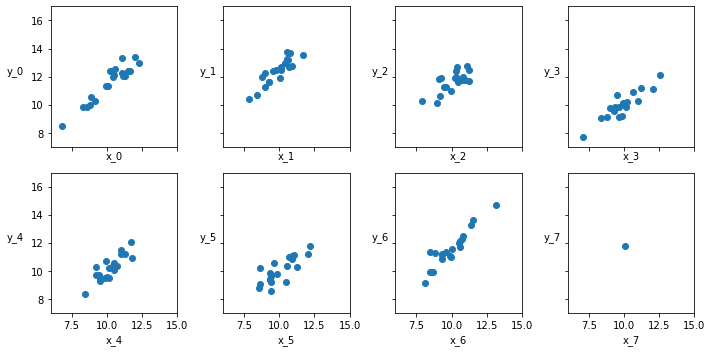

In [53]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

Let's center the data before feeding it into the model:

In [54]:
x_centered = x_m - x_m.mean()

We will first try to fit a non-hierarchical model, we only include the code to rescale $\alpha$ to the original scale.

In [55]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

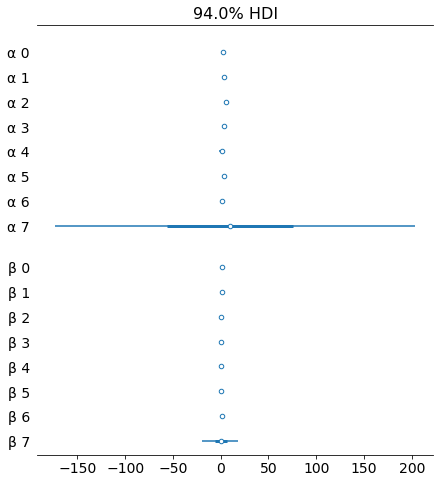

In [57]:
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)